In [212]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as Patch
from scipy.signal import butter, filtfilt
import plots
import functions
import glob
import os
import netCDF4
import numpy.ma as ma 
from matplotlib import rcParams
rcParams['font.family']='sans-serif'
rcParams['font.sans-serif']=['Arial']
import pandas as pd
import scipy.io
import statsmodels.api as sm
from scipy import integrate
from scipy.stats import norm

## 1- Opening data files

In [215]:
bathy = xr.open_dataset('GEBCO_14_May_2025_b03991ce039e/gebco_2024_n75.0_s42.0_w-80.0_e-40.0.nc') 
ds = xr.open_dataset('calval_pass20_all_cycles_zoom.nc', engine="netcdf4") 
# ds = xr.open_dataset('calval_pass20_nearLCC1.nc')
dm = xr.open_dataset('Mooring_data_CalVal/SWOT3_01.nc')

In [217]:
ds

<xarray.Dataset>
Dimensions:               (num_lines: 13167, num_pixels: 69)
Coordinates:
  * num_lines             (num_lines) int64 2040 2041 2042 ... 2170 2171 2172
  * num_pixels            (num_pixels) int64 0 1 2 3 4 5 6 ... 63 64 65 66 67 68
    latitude              (num_lines, num_pixels) float64 ...
    longitude             (num_lines, num_pixels) float64 ...
Data variables:
    time                  (num_lines, num_pixels) datetime64[ns] ...
    ssha_unfiltered       (num_lines, num_pixels) float64 ...
    ssha_filtered         (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    ugos_filtered         (num_lines, num_pixels) float64 ...
    vgos_filtered         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) float32 ...
    mdt                   (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels, num_lines) float64 ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0/PIC2 (NAS...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              0.000612
    geospatial_lon_max:              359.999628
    date_modified:                   2025-03-04T17:37:24Z
    history:                         2025-03-04T17:37:24Z: Created by DUACS K...
    date_created:                    2025-03-04T17:37:24Z
    date_issued:                     2025-03-04T17:37:24Z

In [219]:
wind = xr.open_dataset('Ekman_contribution/ERA5winds.nc') 

time_wind = wind['valid_time'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")

wind = wind.where((wind.valid_time >= start) & (wind.valid_time <= end), drop=True)

In [220]:
time = ds['time'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")

ds = ds.where((ds.time >= start) & (ds.time <= end), drop=True)
# ds.load()  

lon = ds['longitude']
lat = ds['latitude']
ssha = ds['ssha_filtered']
time = ds['time'].values
num_pixels = ds.num_pixels.values
num_lines = ds.num_lines.values
ugeos = ds.ugos_filtered.where(ds.quality_flag==0)
vgeos = ds.vgos_filtered.where(ds.quality_flag==0)

## 2- Selecting values around mooring positions

In [222]:
lon_mooring1 = -53.00083
lat_mooring1 = 50.74967

lon_mooring2 = -53.264167
lat_mooring2 = 50.164667

lon_mooring3 = -52.584277
lat_mooring3 = 49.749922

lon_LCC1 = -55.56367
lat_LCC1 = 53.37517

radius = 10 #km
dist = functions.haversine_distance(ds.latitude, ds.longitude, lat_mooring3, lon_mooring3)
mask = dist < radius
ugeos_mooring1 = ugeos.where(mask)
vgeos_mooring1 = vgeos.where(mask)

omega = 7.2921*1e-5
rho_air = 1.3            # kg/m³
rho_water = 1030           # kg/m³
Cd = 1.3e-3                # Drag coeff (dimensionless)
phi = np.radians(wind.latitude)
f0 = 2*omega*np.sin(phi)
# wind stress (N/m²)
wind_speed = np.sqrt(wind.u10**2 + wind.v10**2)
tau_x = rho_air * Cd * wind.u10 * wind_speed
tau_y = rho_air * Cd * wind.v10 * wind_speed

u_ek = tau_y / (rho_water * f0)   # eastward 
v_ek = -tau_x / (rho_water * f0)  # northward 

distance2 = functions.haversine_distance(wind.latitude, wind.longitude, lat_mooring1, lon_mooring1)
mask2 = distance2 < 10

H_E = 20 

u_ek_vel = u_ek / H_E
v_ek_vel = v_ek / H_E

mean_ek_u = u_ek_vel.where(mask2).mean(dim=['latitude', 'longitude'], skipna=True)
mean_ek_v = v_ek_vel.where(mask2).mean(dim=['latitude', 'longitude'], skipna=True)

# mean_ek_u = mean_ek_u.shift(periods=6)  # shift by 6 hours
# mean_ek_v = mean_ek_v.shift(periods=6)

# ugeos1_mean = []
# vgeos1_mean = []
# for i in num_pixels:
#     ugeos_mooring1_mean = np.mean(ugeos_mooring1[:,i])
#     vgeos_mooring1_mean = np.mean(vgeos_mooring1[:,i])
#     ugeos1_mean.append(ugeos_mooring1_mean)
#     vgeos1_mean.append(vgeos_mooring1_mean)

In [223]:
# output_dir2 = '/Users/dihyachaal/Desktop/Coding/pass20/'
# subset_filenames = sorted(f for f in os.listdir(output_dir2) if f.startswith("subset_") and f.endswith(".nc"))
# subset_paths = [os.path.join(output_dir2, f) for f in subset_filenames]

In [226]:
# datasets = [xr.open_dataset(fp) for fp in subset_paths]
# combined = xr.concat(datasets, dim='file')
# dist2 = functions.haversine_distance(combined.latitude, combined.longitude, lat_mooring3, lon_mooring3)
# mask2 = dist2 < radius
# umask = combined['ugos_filtered'].where(mask2)
# vmask = combined['vgos_filtered'].where(mask2)

In [229]:
# time_mask = combined['time'].where(mask2)
# ugeos3_mean = umask.mean(dim='file')
# vgeos3_mean3 = vmask.mean(dim='file')
# time_mean = combined['time'].mean(dim='file')
# u_mean = combined['ugos_filtered'].mean(dim='file')
# v_mean = combined['vgos_filtered'].mean(dim='file')

## 3- Applying a butter bandpass filter

In [233]:
def find_nearest_index(time, target_time):
    return np.argmin(np.abs(time - target_time))
    
satellite_time = ds.time[:,0].values.astype('datetime64[ns]')
time_indices = [find_nearest_index(wind.valid_time.values.astype('datetime64[ns]'), sat_time) for sat_time in satellite_time]

u_geo_mean = np.nanmean(ugeos_mooring1, axis=1)
v_geo_mean = np.nanmean(vgeos_mooring1, axis=1)

time_dt = pd.to_datetime(time[:, 0])

# Creating arrays with clear indexing
# df_swot_u = pd.DataFrame({
#     'Time': time_dt,
#     'u_total': u_geo_mean 
# }).set_index('Time').resample('1D').mean()

df_swot_u = pd.DataFrame({
    'time': pd.to_datetime(time_dt),
    'u_total': u_geo_mean  # Assuming same length
})

daily = df_swot_u.groupby(df_swot_u['time'].dt.date)
daily_mean = daily['u_total'].mean()
daily_time = daily['time'].apply(lambda x: x.iloc[0])  

# Combining
df_swot_u = pd.DataFrame({
    'time': daily_time.values,
    'u_total_mean': daily_mean.values
}).set_index('time')

df_swot_v = pd.DataFrame({
    'time': pd.to_datetime(time_dt),
    'v_total': v_geo_mean  # Assuming same length
})

daily_v = df_swot_v.groupby(df_swot_v['time'].dt.date)
daily_mean_v = daily_v['v_total'].mean()

df_swot_v = pd.DataFrame({
    'time': daily_time.values,
    'v_total_mean': daily_mean_v.values
}).set_index('time')



# df_swot_v = pd.DataFrame({
#     'Time': time_dt,
#     'v_total': v_geo_mean 
# }).set_index('Time').resample('1D').mean()


def filter_ek(velocity_data, cutoff_hours=48, order=5):
    fs = 1   # 1 sample per hour
    nyquist = 0.5 * fs
    normal_cutoff = (1 / cutoff_hours) / nyquist

    b, a = butter(N=order, Wn=normal_cutoff, btype='low')
    
    return filtfilt(b, a, velocity_data)

df_ek_u = pd.DataFrame({'Time':wind.valid_time, 'Value': mean_ek_u})
df_ek_u['Time'] = pd.to_datetime(df_ek_u['Time'])
df_ek_u = df_ek_u.set_index('Time')
filtered_ek_u = filter_ek(df_ek_u['Value'])

df_ek_v = pd.DataFrame({'Time':wind.valid_time, 'Value': mean_ek_v})
df_ek_v['Time'] = pd.to_datetime(df_ek_v['Time'])
df_ek_v = df_ek_v.set_index('Time')
filtered_ek_v = filter_ek(df_ek_v['Value'])

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_77135/4227143137.py:7: RuntimeWarning: Mean of empty slice
  u_geo_mean = np.nanmean(ugeos_mooring1, axis=1)
/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_77135/4227143137.py:8: RuntimeWarning: Mean of empty slice
  v_geo_mean = np.nanmean(vgeos_mooring1, axis=1)


In [235]:
# df_swot_u['Date'] = df_swot_u.index.date  # Extract date only
# daily_grouped = df_swot_u.groupby('Date')  # You still have minute resolution in index

# # Example: compute mean velocity each day, but retain original timestamps elsewhere
# daily_means = daily_grouped['u_total'].mean()

In [237]:
# print(time[:,0])
# print(satellite_time)
# print(dm.TIME[time_indices])

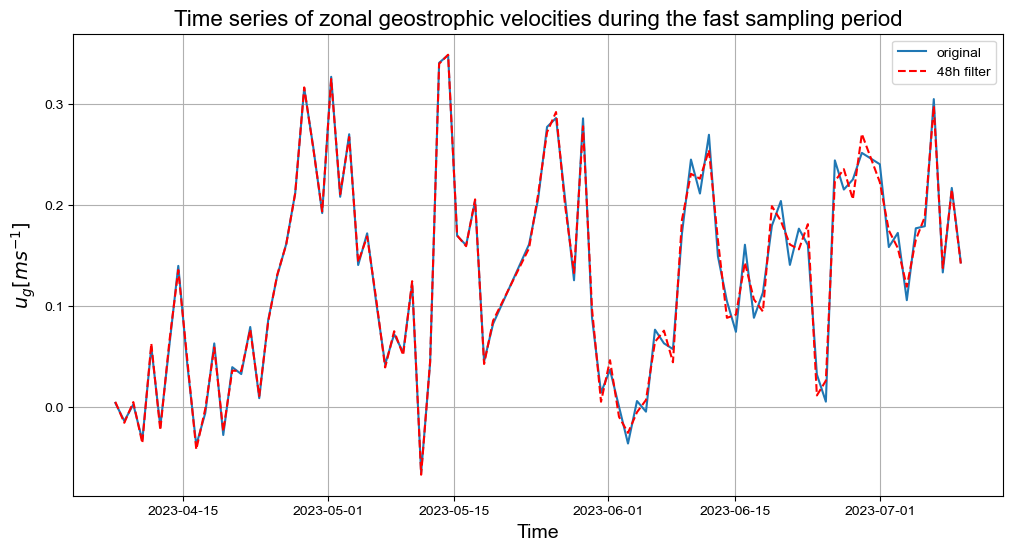

In [239]:
df_interp_swot_u = df_swot_u.interpolate(method='linear')
filtered_swot_u = functions.butter_filter_velocity(df_interp_swot_u.index, df_interp_swot_u['u_total_mean'])

df_interp_swot_v = df_swot_v.interpolate(method='linear')
filtered_swot_v = functions.butter_filter_velocity(df_interp_swot_v.index.day, df_interp_swot_v['v_total_mean'])

plt.figure(figsize=(12, 6))
plt.plot(df_interp_swot_u['u_total_mean'], label='original')
plt.plot(df_swot_u.index, filtered_swot_u, 'r',linestyle='--',label='48h filter')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)
plt.title('Time series of zonal geostrophic velocities during the fast sampling period', fontsize=16)
plt.grid(True)
plt.legend();

In [241]:
filtered_swot_u.shape

(91,)

In [243]:
output_df = pd.DataFrame({'time': df_interp_swot_u.index, 
                          'filtered_u': filtered_swot_u, 'filtered_v':filtered_swot_v})

# output_df = pd.DataFrame({'time': df_swot_u.index, 
#                           'u_geos': df_interp_swot_u['u_total_mean'], 'v_geos':df_interp_swot_v['v_total_mean']})

# output_df.to_csv('swot_ugos_1_final.csv', index=False)

In [245]:
# df_interp_swot_u.index

## 4- Compare to mooring data

In [248]:
time_m = dm['TIME'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")
dm = dm.where((dm.DEPTH <= -10), drop=True)
dm_FS = dm.where((dm.TIME >= start) & (dm.TIME <= end), drop=True)

In [250]:
velocity_east = dm_FS['velocity_east'].values
velocity_north = dm_FS['velocity_north'].values
# bin = dm_FS['bin'].values
depth = dm_FS['DEPTH'].values

In [252]:
np.mean(velocity_east, axis=0)

array([0.13722828, 0.13850975, 0.13966755, 0.14077704, 0.14161126,
       0.1422398 , 0.14250355, 0.14306605, 0.14346941, 0.14432004,
       0.14530319, 0.14623316, 0.14735993, 0.14841933, 0.14959752,
       0.15084796, 0.15166268, 0.15235151, 0.15294858, 0.15329521,
       0.15364406, 0.15398138, 0.15458865, 0.15526995, 0.15665957,
       0.15734264, 0.15808732, 0.15951197, 0.16058688, 0.15619504])

In [254]:
# depth_mask = (depth >= -30) & (depth <= -10)
# depth_mask = (depth >= -40) & (depth <= -15)
# depth_mask = (depth >= -55) & (depth <= -20)
depth_mask = (depth >= -65) & (depth <= -30)
# depth_mask = (depth >= -60) & (depth <= -40)
# depth_mask = (depth >= -70) & (depth <= -55)


# depth_mask = (depth >= -40) & (depth <= -15)
# depth_mask = (depth >= -35) & (depth <= -25)
# depth_mask = (depth >= -40) & (depth <= -30)
# depth_mask = (depth >= -60) & (depth <= -50)
# depth_mask = (depth >= -65) & (depth <= -55)

u_layer = dm_FS.velocity_east.sel(DEPTH=depth_mask)
v_layer = dm_FS.velocity_north.sel(DEPTH=depth_mask)

selected_depths = dm_FS.DEPTH.sel(DEPTH = depth_mask)
print(selected_depths.values)

[-63.99 -61.99 -59.99 -57.99 -55.99 -53.99 -51.99 -49.99 -47.99 -45.99
 -43.99 -41.99 -39.99 -37.99 -35.99 -33.99 -31.99]


In [256]:
def find_nearest_index(time, target_time):
    return np.argmin(np.abs(time - target_time))

satellite_time = np.array(df_swot_u.index) 

time_indices_ek = [find_nearest_index(wind.valid_time.values.astype('datetime64[ns]'), sat_time) for sat_time in satellite_time]

# def find_nearest_index(lon, lat, target_lon, target_lat):
#     d = (lon - target_lon)**2 + (lat - target_lat)**2
#     return np.where(d == np.min(d))[0]
    
# locations=[(-53.00083, 50.74967),
#               (-52.584277, 49.749922)]

# loc_indices = []
# for loc in locations:
#     loc_index = find_nearest_index(lon, lat, *loc)
#     loc_indices.append(loc_index)

# loc_indices

# new_idea = ugeos[loc_indices[0]]
# loc_indices[0]

In [258]:
# df_M1_u = pd.DataFrame({'Time':dm_FS.TIME, 'Value': u_layer.mean(dim=['DEPTH'], skipna=True)})
# df_M1_u['Time'] = pd.to_datetime(df_M1_u['Time'])
# df_M1_u = df_M1_u.set_index('Time')
# df_M1_u = df_M1_u.resample('1D').mean()
# filtered_M1_u = butter_filter_velocity(df_interp_M1_u.index.day, df_interp_M1_u['Value'])




# df_M1_v = pd.DataFrame({'Time':dm_FS.TIME, 'Value': v_layer.mean(dim=['DEPTH'], skipna=True)})
# df_M1_v['Time'] = pd.to_datetime(df_M1_v['Time'])
# df_M1_v = df_M1_v.set_index('Time')
# df_M1_v = df_M1_v.resample('1D').mean()
# filtered_M1_v = butter_filter_velocity(df_interp_M1_v.index.day, df_interp_M1_v['Value'])

In [260]:
# u = u_ek.mean(dim=['valid_time'], skipna=True) 
# v = v_ek.mean(dim=['valid_time'], skipna=True) 

# u_area = u_wind.mean(dim=['valid_time'], skipna=True) 
# v_area = v_wind.mean(dim=['valid_time'], skipna=True) 

# M_ek = (np.sqrt(u_wind**2 + v_wind**2))/40

# ek_u = pd.DataFrame({'Time':wind.valid_time, 'Value': u_wind.mean(dim=['latitude', 'longitude'], skipna=True) })
# ek_u['Time'] = pd.to_datetime(ek_u['Time'])
# ek_u = ek_u.set_index('Time')
# # ek_u_new =ek_u.resample('1D').mean()
# # filtered_u_ek = butter_filter_velocity(ek_u_interp.index.day, ek_u_interp['Value'])

# ek_v = pd.DataFrame({'Time':wind.valid_time, 'Value': v_wind.mean(dim=['latitude', 'longitude'], skipna=True) })
# ek_v['Time'] = pd.to_datetime(ek_v['Time'])
# ek_v = ek_v.set_index('Time')
# # ek_v_new =ek_v.resample('1D').mean()
# ek_v_interp = ek_v_new.interpolate(method='linear')
# filtered_v_ek = butter_filter_velocity(ek_v_interp.index.day, ek_v_interp['Value'])

# M_ek = pd.DataFrame({'Time':wind.valid_time, 'Value': M_ek.mean(dim=['latitude', 'longitude'], skipna=True) })
# M_ek['Time'] = pd.to_datetime(M_ek['Time'])
# M_ek = M_ek.set_index('Time')
# M_ek_new =M_ek.resample('1D').mean()
# filtered_M_ek = butter_filter_velocity(M_ek_interp.index.day, M_ek_interp['Value'])

In [262]:
# ek_layer = (depth >= -30) & (depth <= -10)

# u_surf = dm_FS.velocity_east.sel(DEPTH=ek_layer)
# v_surf = dm_FS.velocity_north.sel(DEPTH=ek_layer)

# u_surf_mean = u_surf.mean(dim='DEPTH')
# v_surf_mean = v_surf.mean(dim='DEPTH')

In [264]:
dm_u_layer = pd.DataFrame({'Time':dm_FS.TIME, 'Value': np.nanmean(u_layer, axis=1)})
dm_u_layer = dm_u_layer.set_index('Time')
dm_u_layer = dm_u_layer.resample('1h').mean()
filtered_u_layer = functions.filter_velocity(dm_u_layer['Value'])

dm_v_layer = pd.DataFrame({'Time':dm_FS.TIME, 'Value': np.nanmean(v_layer, axis=1)})
dm_v_layer = dm_v_layer.set_index('Time')
dm_v_layer = dm_v_layer.resample('1h').mean()
filtered_v_layer = functions.filter_velocity(dm_v_layer['Value'])

time_indices = [find_nearest_index(dm_u_layer.index, sat_time) for sat_time in satellite_time]

In [266]:
u_mooring = np.sqrt(filtered_u_layer[time_indices]**2 + filtered_v_layer[time_indices]**2)
u_swot =  np.sqrt(filtered_swot_u**2 +  filtered_swot_v**2)

corr = np.abs(np.corrcoef(filtered_u_layer[time_indices], filtered_swot_u+filtered_ek_u[time_indices_ek])[0,1])
rmse = np.sqrt(np.mean((filtered_u_layer[time_indices] - filtered_swot_u+filtered_ek_u[time_indices_ek])**2)) 
print(f"correlation:", corr)
print(f"rmse:", rmse) 

correlation: 0.6912006038695026
rmse: 0.09367689419953075


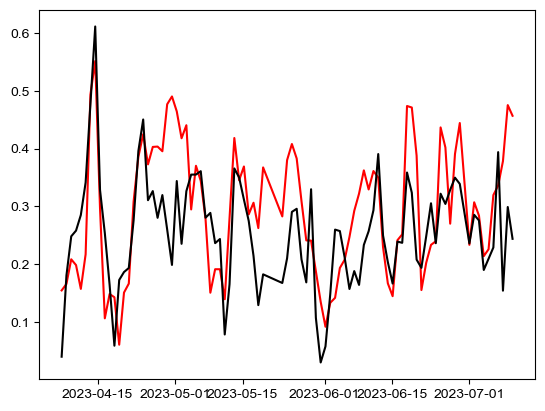

In [268]:
plt.plot(satellite_time, u_mooring, 'r')
plt.plot(satellite_time, u_swot, 'k')

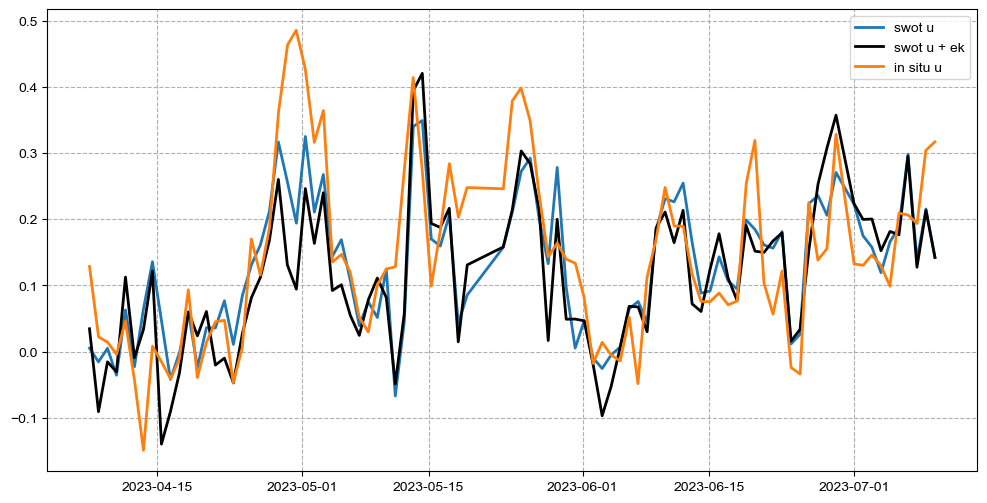

In [270]:
plt.figure(figsize=(12, 6))
plt.plot(df_swot_u.index, filtered_swot_u, linewidth=2, label='swot u')
plt.plot(df_swot_u.index, filtered_swot_u + mean_ek_u[time_indices_ek], linewidth=2, c='k', label='swot u + ek')
plt.plot(dm_u_layer.index[time_indices], filtered_u_layer[time_indices], linewidth = 2, label='in situ u');

# plt.plot(df_swot_v.index, filtered_swot_v, linestyle='--', label = 'swot v')
# plt.plot(df_swot_v.index, filtered_swot_v + mean_ek_v[time_indices_ek], c='k', linestyle='--', label = 'swot v + ek')
# plt.plot(dm_v_layer.index[time_indices], filtered_v_layer[time_indices], linestyle='--', label = 'in situ v')
plt.legend()
plt.grid(linestyle='--')
# plt.savefig('comparison.png', dpi=300);

In [272]:
# mask_nan = ~np.isnan(df_swot_u['u_total_mean']) & ~np.isnan(filtered_u_layer[time_indices])
# u_mooring = filtered_u_layer[time_indices][mask_nan]
# u_swot = df_swot_u['u_total_mean'][mask_nan]
# v_mooring = filtered_v_layer[time_indices][mask_nan]
# v_swot = df_swot_v['v_total_mean'][mask_nan]

In [274]:
# corr_u = np.abs(np.corrcoef(u_mooring, u_swot)[0,1])
# rmse_u = np.sqrt(np.mean((u_mooring-u_swot)**2)) 
# print(f"correlation:", corr_u)
# print(f"rmse:", rmse_u) 
# corr_v = np.abs(np.corrcoef(v_mooring, v_swot)[0,1])
# rmse_v = np.sqrt(np.mean((v_mooring-v_swot)**2)) 
# print(f"correlation:", corr_v)
# print(f"rmse:", rmse_v) 

In [276]:
corr = np.abs(np.corrcoef(filtered_v_layer[time_indices], filtered_swot_v + mean_ek_v[time_indices_ek])[0,1])
corr2 = np.abs(np.corrcoef(filtered_v_layer[time_indices], filtered_swot_v)[0,1])

corr_u = np.abs(np.corrcoef(filtered_u_layer[time_indices], filtered_swot_u + mean_ek_u[time_indices_ek])[0,1])
corr2_u = np.abs(np.corrcoef(filtered_u_layer[time_indices], filtered_swot_u)[0,1])
# rmse = np.sqrt(np.mean((filtered_u_layer[time_indices]-filtered_swot_u)**2)) 
rmse2 = np.sqrt(np.mean((filtered_u_layer[time_indices]-filtered_swot_u)**2)) 
print(f"correlation without Ekman contribution:", corr2)
print(f"correlation:", corr)
print(f"correlation without Ekman contribution:", corr2_u)
print(f"correlation:", corr_u)
print(f"rmse:", rmse2) 
# print(f"rmse:", rmse) 

correlation without Ekman contribution: 0.7367868563366757
correlation: 0.6540107559698116
correlation without Ekman contribution: 0.7636160228573017
correlation: 0.688068459002662
rmse: 0.08650084980503275


In [278]:
mooring_speed = np.sqrt(filtered_u_layer[time_indices]**2 + filtered_v_layer[time_indices]**2)
sat_speed = np.sqrt(filtered_swot_u**2+filtered_swot_v**2)
sat_total_speed = np.sqrt((filtered_swot_u + mean_ek_u[time_indices_ek])**2 +
                          (filtered_swot_v + mean_ek_v[time_indices_ek])**2)
RMSD_before = np.sqrt((np.mean(mooring_speed - sat_speed))**2)
RMSD_after = np.sqrt((np.mean(mooring_speed - sat_total_speed))**2)

corr_speed = np.abs(np.corrcoef(mooring_speed, sat_speed))[0,1]

corr_before = np.corrcoef(mooring_speed, sat_speed)[0,1]
corr_after  = np.corrcoef(mooring_speed, sat_total_speed)[0,1]
print("Correlation without Ekman:", corr_before)
print("Correlation with Ekman:   ", corr_after)
print("RMSD without Ekman:", RMSD_before)
print("RMSD with Ekman:   ", RMSD_after)

Correlation without Ekman: 0.6272225541214641
Correlation with Ekman:    0.45544078799966464
RMSD without Ekman: 0.03838960985107499
RMSD with Ekman:    <xarray.DataArray ()>
array(0.04075415)
Coordinates:
    number   int64 0


TypeError: 'module' object is not callable

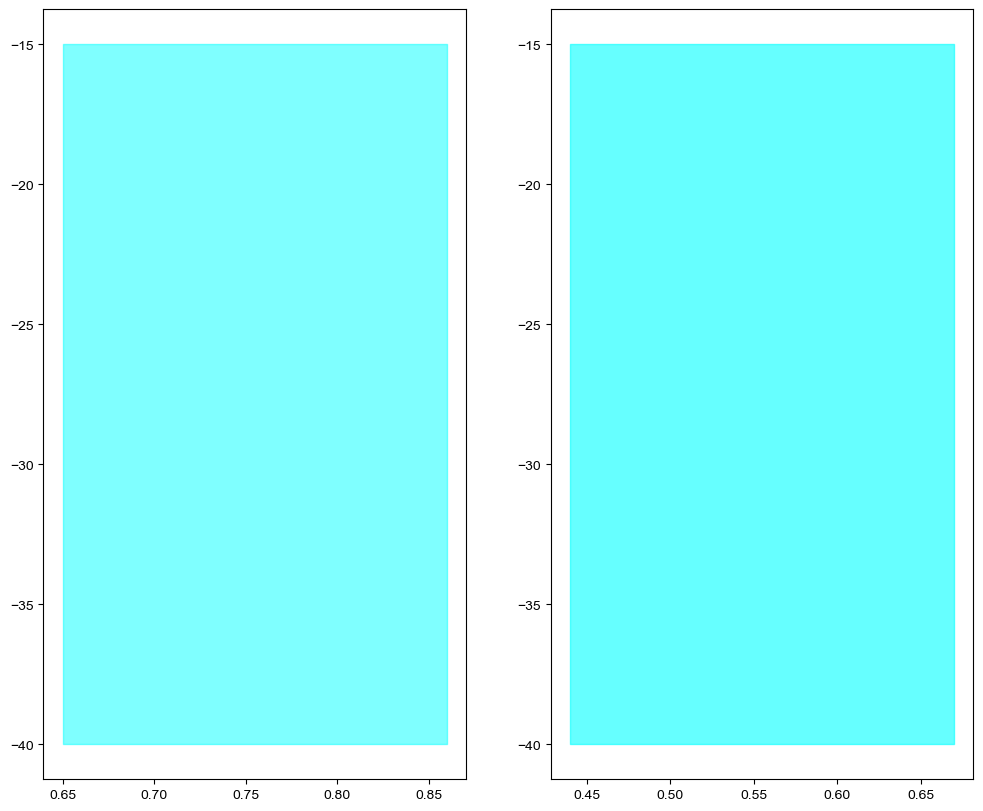

In [280]:
x = [0.84, 0.81, 0.81, 0.79, 0.80]
x2 = [0.67, 0.71, 0.72, 0.76, 0.77]

v = [0.63, 0.65, 0.65, 0.63, 0.63]
v2 = [0.46, 0.54, 0.56, 0.59, 0.60]

# y = [-20, -27.5, -37.5, -47.5, -50, -62.5]  

# Depth bounds for shaded layers
layer_bounds = [(-40, -15), (-40, -30), (-50, -40), (-60, -50), (-65, -55)]

y = []
for i in layer_bounds:
    mean_layer = np.mean(i)
    y.append(mean_layer)
    
colors = ['aqua', 'deepskyblue', 'dodgerblue', 'b', 'mediumblue']

labels = ['Layer 1 (10-30m)', 
          'Layer 2 (15-40m)', 
          'Layer 3 (20-55m)', 
          'Layer 4 (30-65m)', 
          'Layer 5 (40-60m)', 
          'Layer 6 (55-70m)']

# labels = ['Layer 1 (10m)', 
#           'Layer 2 (20m)', 
#           'Layer 3 (30m)', 
#           'Layer 4 (40m)', 
#           'Layer 5 (50m)']

# fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(12, 10))  
# plt.suptitle('Velocité East, North', size = 'x-large')
patches = []
for (dmin, dmax), label, color in zip(layer_bounds,labels, colors):
    ax[0].fill_betweenx(y=[dmin, dmax], x1=min(x2)-0.02, x2=max(x)+0.02, color=color, alpha=0.5)
    ax[1].fill_betweenx(y=[dmin, dmax], x1=min(v2)-0.02, x2=max(v)+0.02, color=color, alpha=0.6)
    patches.append(Patch(facecolor=color, edgecolor='black', alpha=1, label=label))
    
# Plot points
for xi, yi, color in zip(x, y, colors):
    ax[0].scatter(xi, yi, color=color, edgecolor='black', s=100, zorder=4, label='swot')
ax[0].plot(x, y, 'k', zorder=3)
ax[0].plot(x2, y, 'k', linestyle='--',zorder=1)
for vi, yi, color in zip(v, y, colors):
    ax[1].scatter(vi, yi, color=color, edgecolor='black', s=80, zorder=3, label='swot')
    
for xi2,yi, color in zip(x2,y, colors):
    star = ax[0].scatter(xi2, yi, color=color, marker='*', edgecolor='black', s=100, zorder=4, label = 'SWOT-Ekman transport')   

for vi2,yi, color in zip(v2,y, colors):
    ax[1].scatter(vi2, yi, color=color, marker='*', edgecolor='black', s=80, zorder=3, label = 'SWOT-Ekman transport')   

ax[1].plot(v, y, 'k', zorder=1)
ax[1].plot(v2, y, 'k', linestyle='--',zorder=1)


ax[0].set_title('Variation of the r between the mean u_geos of SWOT \nand SWOT1-01 as a function of the mooring layer depth', fontsize=14)
ax[0].set_xlabel('Correlation', fontsize=14)
ax[0].set_ylabel('Depth [m]', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.5)
ax[0].set_xlim(min(x2) - 0.01, max(x) + 0.01)
ax[0].set_ylim(-65, -15)
ax[0].set_yticks([-15, -20, -30, -40,-50,-60,-65], ['15', '20', '30', '40', '50', '60', '65'], fontsize=12)
legend_handles = patches + [star]
ax[0].legend(handles=legend_handles, title='Depth Layers', loc='upper right', fontsize=9, title_fontsize=10)

ax[1].set_title('Variation of the r between the mean v_geos of SWOT and SWOT1-01 \nas a function of the mooring layer depth', fontsize=14)
ax[1].set_xlabel('Correlation', fontsize=14)
# ax[1].set_ylabel('Depth [m]', fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[1].set_xlim(min(v2) - 0.01, max(v) + 0.01)
ax[1].set_ylim(-65, -15)
ax[1].set_yticks([-15, -20, -30, -40,-50,-60,-65], ['15', '20', '30', '40', '50', '60', '65'], fontsize=12)
legend_handles = patches + [star]
# ax.legend(handles=legend_handles, title='Depth Layers', loc='lower right', fontsize=9, title_fontsize=10)
plt.tight_layout()
# plt.savefig('RvsZ1_bis.png', dpi=300);

Better when we take Ekman in the top layer. Below 15 m it is better to not take into account the Ekman contribution.

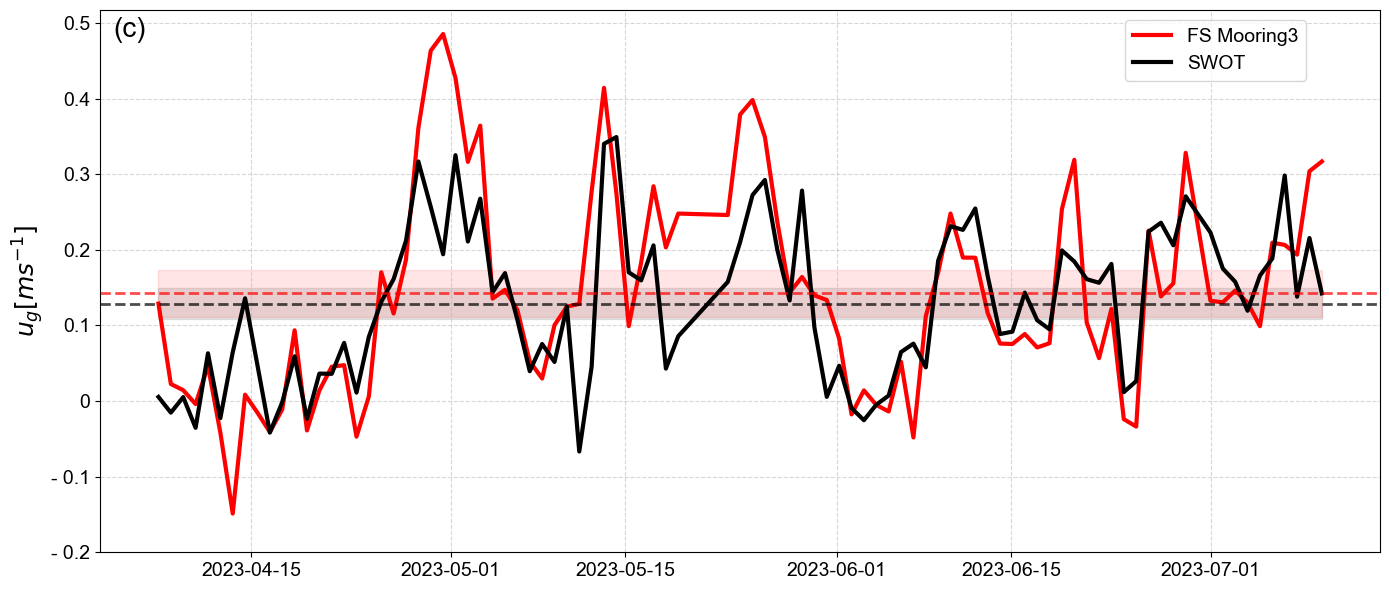

In [283]:
plt.figure(figsize=(14, 6))

plt.plot(satellite_time, filtered_u_layer[time_indices], label='FS Mooring3', color='r', linewidth=3)

plt.plot(df_interp_swot_u.index, filtered_swot_u, label='SWOT', color='k', linewidth=3)

plt.text(0.01, 0.95, "(c)", fontsize=20, transform=plt.gca().transAxes)

plt.tick_params(axis='x', labelsize=14, colors='k')
# plt.tick_params(axis='y', labelsize=14, colors='k')
plt.fill_between(df_interp_swot_v.index, mean_u - (std_u/np.sqrt(91/3.74)), mean_u + (std_u/np.sqrt(91/3.74)), color='gray', alpha=0.2)
plt.fill_between(df_interp_swot_v.index, mean_u_m - (std_u_m/np.sqrt(91/4.99)), mean_u_m + (std_u_m/np.sqrt(91/4.99)), color='r', alpha=0.1)
plt.axhline(mean_u, color='k', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(mean_u_m, color='r', linestyle='--', linewidth=2,alpha=0.7)
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4,0.5], ['- 0.2','- 0.1','0', '0.1', '0.2', '0.3', '0.4','0.5'], fontsize=14)
plt.ylabel(r'$u_{g} [m s^{-1}]$', fontsize=18)
# plt.title('Time series of geostrophic zonal velocities during the fast sampling period', fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(0.95, 1), fontsize=14)
plt.tight_layout()
# plt.savefig('Figures/SWOTvsM3.png', dpi=300);

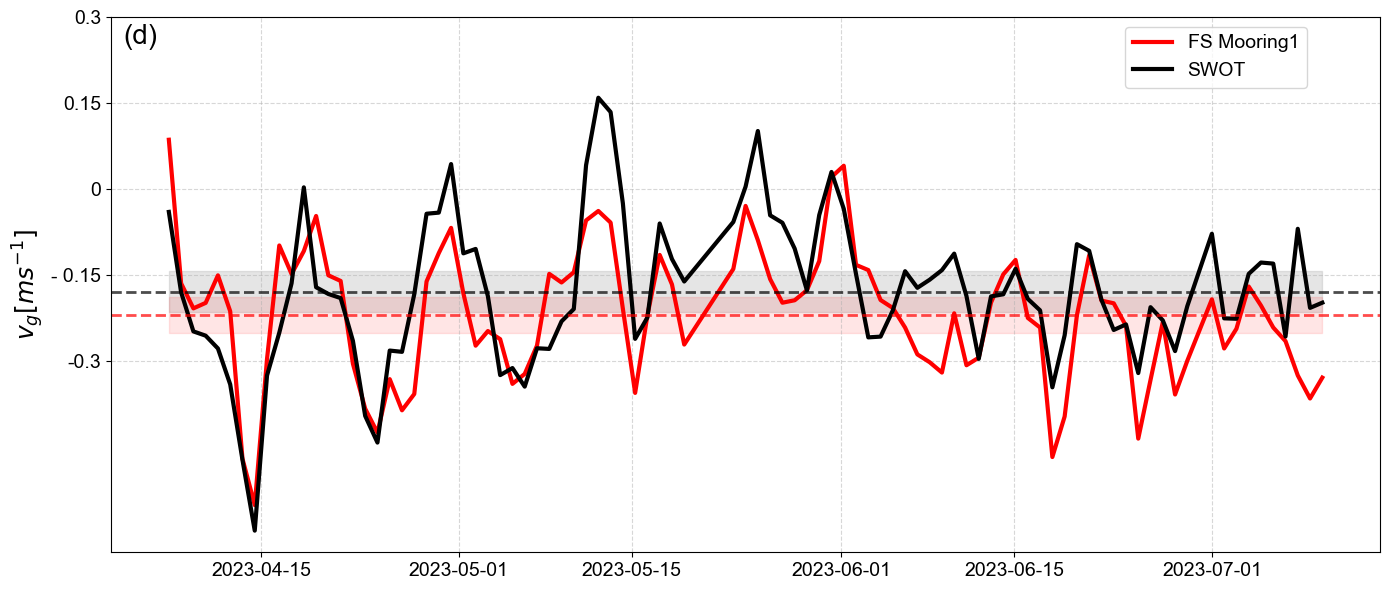

In [285]:
plt.figure(figsize=(14, 6))

plt.plot(satellite_time, filtered_v_layer[time_indices], label='FS Mooring1', color='r', linewidth=3)
plt.plot(df_interp_swot_v.index, filtered_swot_v, label='SWOT', color='k', linewidth=3)

plt.text(0.01, 0.95, "(d)", fontsize=20, transform=plt.gca().transAxes)

plt.tick_params(axis='x', labelsize=14, colors='k')
plt.fill_between(df_interp_swot_v.index, mean_v - (std_v/np.sqrt(91/7.22)), mean_v + (std_v/np.sqrt(91/7.22)), color='gray', alpha=0.2)
plt.fill_between(df_interp_swot_v.index, mean_v_m - (std_v_m/np.sqrt(91/6.91)), mean_v_m + (std_v_m/np.sqrt(91/6.91)), color='r', alpha=0.1)
plt.axhline(mean_v, color='k', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(mean_v_m, color='r', linestyle='--', linewidth=2,alpha=0.7)
plt.yticks([-0.3, -0.15, 0, 0.15, 0.3], ['-0.3','- 0.15','0', '0.15', '0.3'], fontsize=14)


plt.ylabel(r'$v_{g} [m s^{-1}]$', fontsize=18)
# plt.title('Time series of geostrophic meridional velocities during the fast sampling period', fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(0.95, 1), fontsize=14)
plt.tight_layout()
# plt.savefig('Figures/SWOTvsM1_v.png', dpi=300);

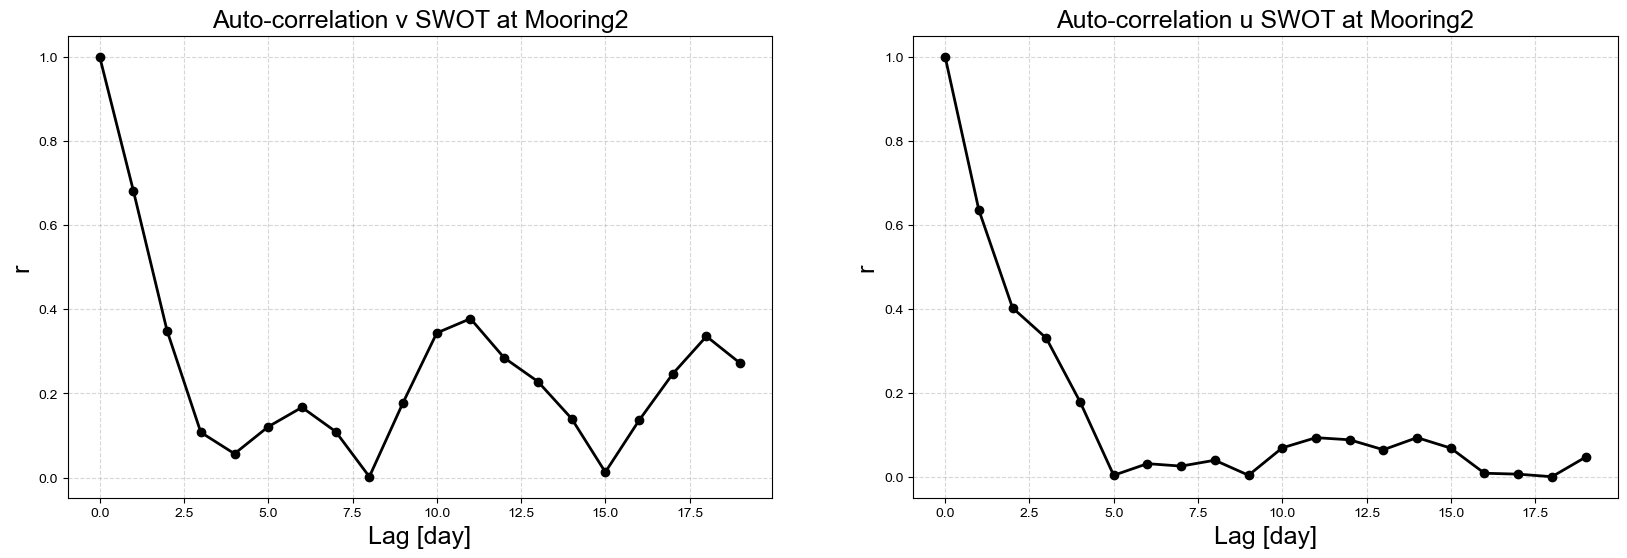

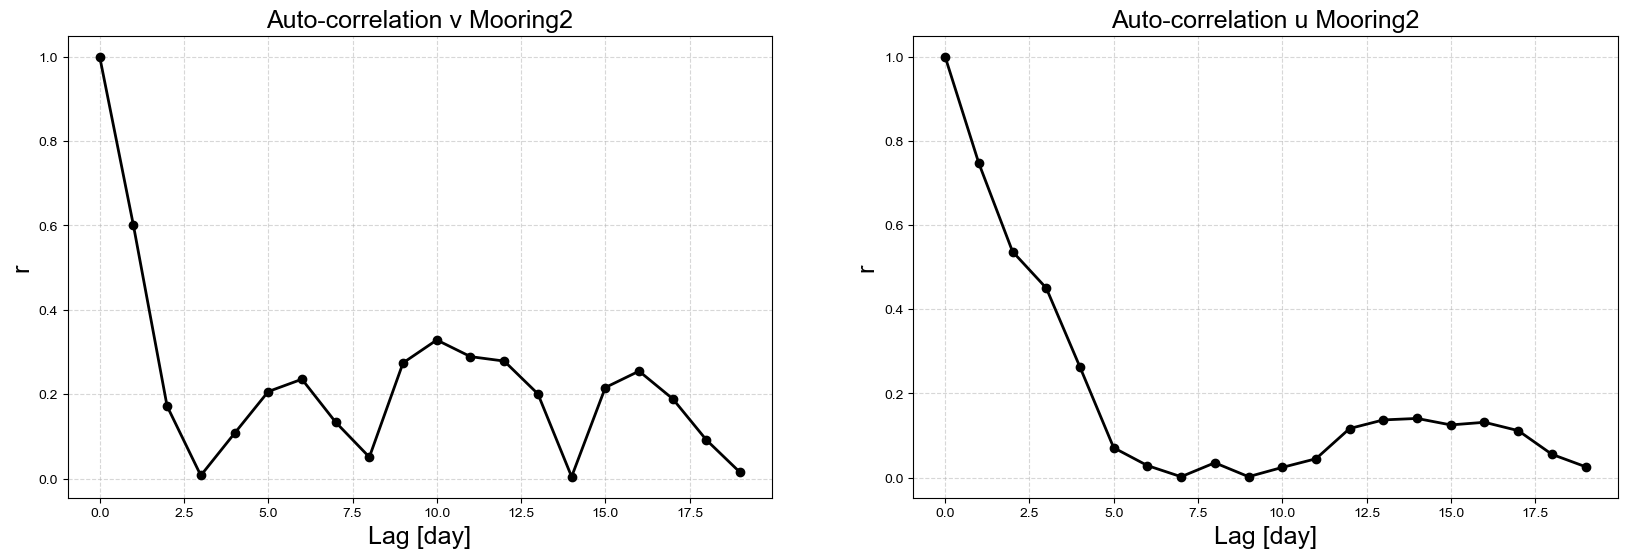

In [289]:
u_auto_r = sm.tsa.acf(filtered_swot_u)
v_auto_r = sm.tsa.acf(filtered_swot_v)
lags = np.arange(len(u_auto_r))
fig, axs = plt.subplots(1,2, figsize=(20, 6))

axs[1].plot(lags, np.abs(u_auto_r), marker='o', color='k', linewidth=2, label='u')
axs[1].set_xlabel('Lag [day]', fontsize=18)
axs[1].set_ylabel('r', fontsize=18)
axs[1].set_title('Auto-correlation u SWOT at Mooring2', fontsize=18)
axs[1].grid(alpha=0.5, linestyle='--')
# axs[1].legend()

axs[0].plot(lags, np.abs(v_auto_r), marker = 'o', color='k', linewidth=2, label='v')
axs[0].set_xlabel('Lag [day]', fontsize=18)
axs[0].set_ylabel('r', fontsize=18)
axs[0].set_title('Auto-correlation v SWOT at Mooring2', fontsize=18)
axs[0].grid(alpha=0.5, linestyle='--')
# axs[0].legend()

u_auto_rm = sm.tsa.acf(filtered_u_layer[time_indices])
v_auto_rm = sm.tsa.acf(filtered_v_layer[time_indices])
fig, axs = plt.subplots(1,2, figsize=(20, 6))

axs[1].plot(lags, np.abs(u_auto_rm), marker='o', color='k', linewidth=2, label='u')
axs[1].set_xlabel('Lag [day]', fontsize=18)
axs[1].set_ylabel('r', fontsize=18)
axs[1].set_title('Auto-correlation u Mooring2', fontsize=18)
axs[1].grid(alpha=0.5, linestyle='--')
# axs[1].legend()


axs[0].plot(lags, np.abs(v_auto_rm), marker = 'o', color='k', linewidth=2, label='v')
axs[0].set_xlabel('Lag [day]', fontsize=18)
axs[0].set_ylabel('r', fontsize=18)
axs[0].set_title('Auto-correlation v Mooring2', fontsize=18)
axs[0].grid(alpha=0.5, linestyle='--')
# axs[0].legend()


# plt.savefig('SWOTvsM2.png', dpi=300)
plt.show();

In [290]:
integral = np.trapz(np.abs(v_auto_rm)[0:7], x= lags[0:7])
integral

1.710860967349863

In [293]:
mean_u = np.nanmean(filtered_swot_u)
mean_u_m = np.nanmean(filtered_u_layer[time_indices])

std_u = np.nanstd(filtered_swot_u)
std_u_m = np.nanstd(filtered_u_layer[time_indices])

mean_v = np.nanmean(filtered_swot_v)
mean_v_m = np.nanmean(filtered_v_layer[time_indices])

std_v = np.nanstd(filtered_swot_v)
std_v_m = np.nanstd(filtered_v_layer[time_indices])

In [301]:
def effective_sample_size(variable, alpha=0.05, nlags=40):
    """
    Calculate the independant sample size by accounting for autocorrelation as follow:
    It determines the critical value for significance by 
    calculating the width of the confidence interval
    It finds the lag K where the ACF drops below the critical value ie where it is no longer 
    significant
    """
    N = len(variable)

    acf_vals, confint = sm.tsa.acf(variable, alpha=alpha, fft=True, nlags=nlags)
    
    se = 1.0 / np.sqrt(N)
    
    p_values_v = 2 * (1 - norm.cdf(np.abs(acf_vals) / se))

    ci_width = confint[:,1] - acf_vals 
    
    crit = ci_width[1]  
    
    try:
        K = np.where(np.abs(acf_vals) < crit)[0][0]
    except IndexError:
        K = nlags  

    tau = 1 + 2 * np.sum(acf_vals[1:K])
    # tau = 1 + 2 * np.trapz(np.abs(acf_vals[1:K]), x= lags[0:K])
    
    n_eff = int(N / tau)

    return acf_vals, confint, n_eff, tau, K

u_acf, u_confint, n_eff_u, tau_u, K_u = effective_sample_size(filtered_u_layer[time_indices])
v_acf, v_confint, n_eff_v, tau_v, K_v = effective_sample_size(filtered_v_layer[time_indices])

print(f"U-series: N = {len(filtered_u_layer[time_indices])}, tau ≈ {tau_u:.2f}, n_eff ≈ {n_eff_u}")
print(f"V-series: N = {len(filtered_v_layer[time_indices])}, tau ≈ {tau_v:.2f}, n_eff ≈ {n_eff_v}")

SE_u = std_u / np.sqrt(n_eff_u)
SE_v = std_v / np.sqrt(n_eff_v)
print(f"SE_u = {SE_u:.4f}, SE_v = {SE_v:.4f}")

U-series: N = 91, tau ≈ 4.99, n_eff ≈ 18
V-series: N = 91, tau ≈ 2.20, n_eff ≈ 41
SE_u = 0.0235, SE_v = 0.0197


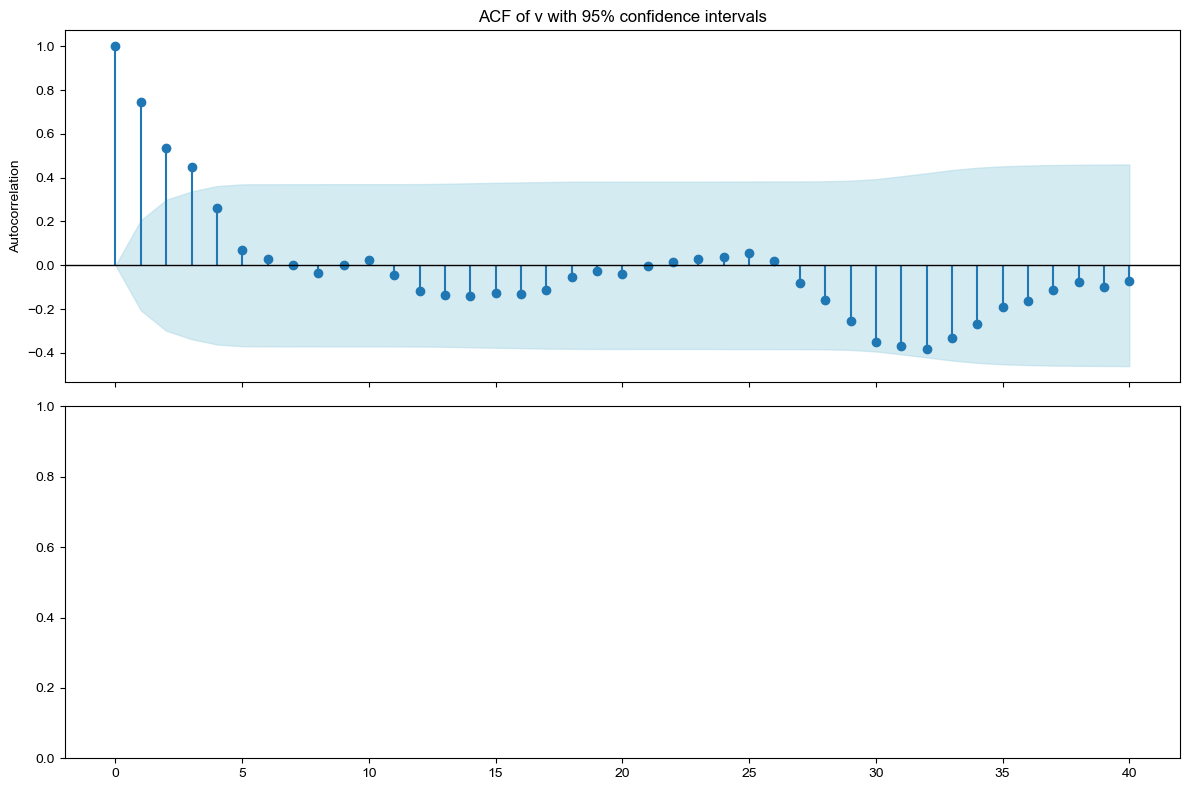

In [303]:
lags = np.arange(len(u_acf))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].stem(lags, u_acf, basefmt=" ", linefmt="C0-", markerfmt="C0o")
axes[0].fill_between(lags, u_confint[:,0] - u_acf, u_confint[:,1]-u_acf,
                     color="lightblue", alpha=0.5)
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("ACF of v with 95% confidence intervals")
axes[0].set_ylabel("Autocorrelation")

# axes[1].plot(lags, p_values_v, marker="o", linestyle="-", color="C1")
# axes[1].axhline(0.05, color="red", linestyle="--", label="p = 0.05")
# axes[1].set_title("p-values for autocorrelations of u")
# axes[1].set_xlabel("Lag")
# axes[1].set_ylabel("p-value")
# axes[1].legend()

plt.tight_layout()


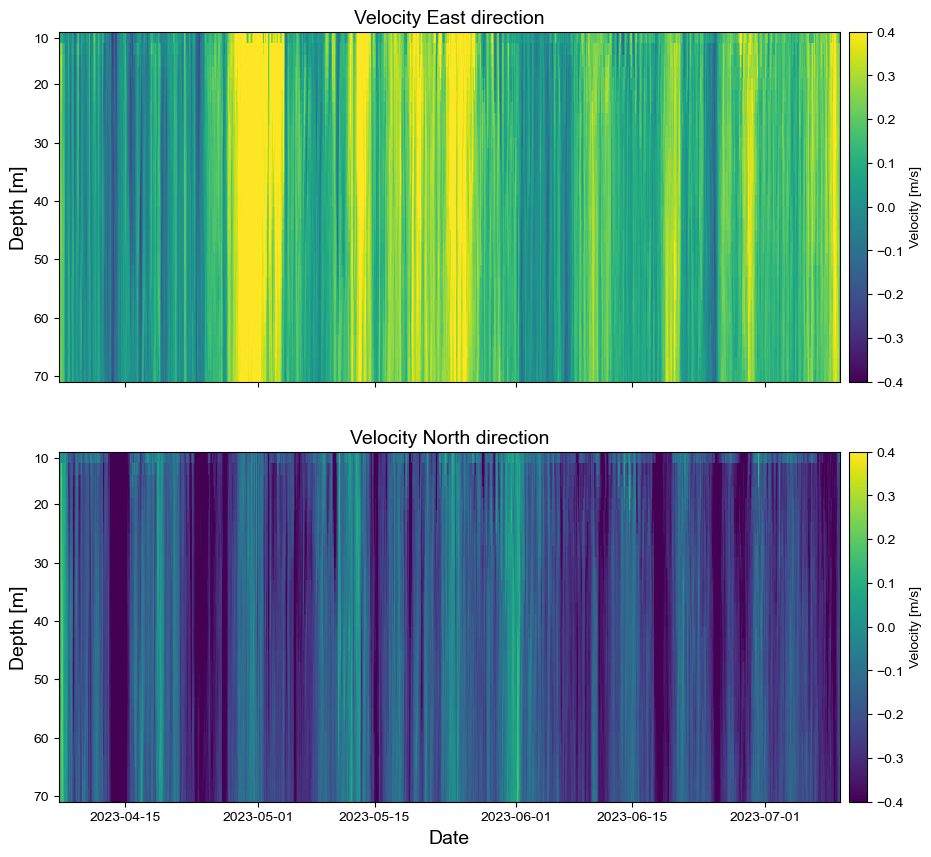

In [305]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 4 rows, 1 column
# plt.suptitle('Velocity East and North', size = 'x-large')
pcm0 = axs[0].pcolormesh(dm_FS.TIME, depth , velocity_east.T, cmap='viridis', vmin=-0.4,vmax=0.4)
# quiver = axs[0].quiver(dm_FS.TIME, depth , velocity_east.T,velocity_north.T, scale=25)
axs[0].set_title('Velocity East direction', fontsize=14)
axs[0].set_ylabel('Depth [m]', fontsize=14)
axs[0].set_xticklabels([]) 
cbar0 = plt.colorbar(pcm0, ax=axs[0], label='Velocity [m/s]', shrink=1, pad=0.01)
axs[0].set_yticks([-11.99, -20, -30, -40,-50,-60,-70], ['10', '20', '30', '40', '50', '60', '70'])

pcm1 = axs[1].pcolormesh(dm_FS.TIME, depth, velocity_north.T, cmap='viridis', vmin=-0.4,vmax=0.4)
axs[1].set_title('Velocity North direction', fontsize=14)
axs[1].set_ylabel('Depth [m]', fontsize=14)
cbar1 = plt.colorbar(pcm1, ax=axs[1], label='Velocity [m/s]', shrink=1, pad=0.01)
axs[1].set_xlabel('Date', fontsize=14)
axs[1].set_yticks([-11.99, -20, -30, -40,-50,-60,-70], ['10', '20', '30', '40', '50', '60', '70']);
# fig.savefig("Figures/velocity_pcm_M3.png", dpi=300)  ;

In [307]:
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6, 8))

# mean_u = np.nanmean(velocity_east, axis=0)
# std_u = np.nanstd(velocity_east, axis=0)
# ax1.plot(mean_u, depth, c='k',linewidth=2,label='mean u')
# ax1.fill_betweenx(depth, mean_u - std_u, mean_u + std_u, color='gray', alpha=0.2, label='±1 std')
# ax1.set_xlabel(r'$u~[m.s^{-1}]$', fontsize=14)
# ax1.set_ylabel('DEPTH [m]',fontsize=14)
# ax1.grid(True, linestyle='-',alpha=0.4)
# ax1.set_xlim(-0.4, 0.4)


# # ax2 = ax1.twiny()
# mean_v = np.nanmean(velocity_north, axis=0)
# std_v = np.nanstd(velocity_north, axis=0)
# ax2.plot(mean_v, depth, linestyle='-', linewidth=2, c='blue',label='mean v')
# ax2.fill_betweenx(depth, mean_v - std_v, mean_v + std_v, color='lightblue', alpha=0.2, label='±1 std')
# ax2.grid(True, linestyle='-',alpha=0.4)
# ax2.set_xlim(-0.5, 0.5)
# ax2.set_xlabel(r'$v~[m.s^{-1}]$', fontsize=14)

# plt.title('')

# # lines1, labels1 = ax1.get_legend_handles_labels()
# # lines2, labels2 = ax2.get_legend_handles_labels()
# # ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
# plt.suptitle('Mooring SWOT3.01 velocity profile')
# # plt.savefig('Figures/velociticy_SWOT3_profile.png', dpi=300)
# plt.show()